In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/WhenPigsFlyContext/baselines/IVSN

! pip install ml-collections
!pip3 install pickle5

In [ ]:
import sys
import cv2
from google.colab.patches import cv2_imshow
import time
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
import numpy as np
import pandas as pd
import pickle
import pickle5 as pickle5
import random
from random import sample
import copy

import os
import shutil
from PIL import Image, ImageDraw

import torch
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor, normalize, to_pil_image
from torchvision import transforms

from utils import *
from SCEGRAM.SCEGRAM import SCEGRAM
sys.path.append("..")

In [ ]:
context_dir = "../../SCEGRAM/01scenes/01object_present"
# target_dir = "../../SCEGRAM/02objects"
target_dir = "../../SCEGRAM/invariant_objects"
info_dir = "../../SCEGRAM/SCEGRAM_Database_scenes_objects.xlsx"
context_size, target_size = (320, 512), (128, 128)
dataset = SCEGRAM(info_dir, context_dir, target_dir, context_size, target_size)

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
with open("[SCEGRAM]bin_idxs.pkl", "rb") as tf:
    bin_info = pickle5.load(tf) 

In [ ]:
# define IVSN model
class IVSN_sti(nn.Module):
  def __init__(self, model):
      super(IVSN_sti, self).__init__()
      self.features = nn.Sequential(*list(model.children())[0][:30])
      for param in self.features.parameters():
        param.requires_grad_ = False

  def forward(self, x):
      x = self.features(x)
      return x

class IVSN_tg(nn.Module):
  def __init__(self, model):
      super(IVSN_tg, self).__init__()
      self.features = nn.Sequential(*list(model.children())[0][:30])
      self.pool_layer = nn.AdaptiveMaxPool2d((1, 1))
      for param in self.features.parameters():
        param.requires_grad_ = False

  def forward(self, x):
      x = self.features(x)
      x = self.pool_layer(x)
      return x

from torch.nn.modules.conv import Conv2d
ConvSize, NumTemplates, Mylayer = 1, 512, 31
MMconv = Conv2d(NumTemplates, 1, kernel_size = (ConvSize, ConvSize), stride = (1, 1), padding = (1, 1))

In [ ]:
model_vgg = models.vgg16(pretrained=True)
model_ivsn_sti = IVSN_sti(model_vgg)
model_ivsn_tg = IVSN_tg(model_vgg)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
num_pics, size, image_size = len(dataset), 48, (320, 512)
radio_dict_con, radio_dict_incon = {}, {}

for id in trange(0, num_pics):
    context_images, target_images, bbox, category = dataset[id]
    tg_loc = bbox_cordinates(bbox, image_size[1], image_size[0])
    ratio = (tg_loc[-1]*tg_loc[-2]) / (image_size[0]*image_size[1])

    if category == "CON":
        radio_dict_con[id] = ratio
    elif category != "CON":
        radio_dict_incon[id] = ratio

100%|██████████| 372/372 [04:00<00:00,  1.54it/s]


In [ ]:
bin_info['incon_(0, 25]']

In [ ]:
num_pics, size, image_size = len(dataset), 48, (320, 512)
IVSN_res, scanpath, attention_map = [], [], []
IVSN_CON_0_25, IVSN_CON_25_50  = [], [], [], []
IVSN_INCON_0_25, IVSN_INCON_25_50  = [], [], [], []

model_ivsn_sti.eval()
model_ivsn_tg.eval()
with torch.no_grad():
    for id in trange(0, num_pics):
        context_images, target_images, bbox, category = dataset[id]

        # get attention map from IVSN model
        context_ivsn = context_images.unsqueeze(0)
        target_ivsn = target_images.unsqueeze(0)
        cont_output_ivsn = model_ivsn_sti(context_ivsn)
        tg_output_ivsn = model_ivsn_tg(target_ivsn)
        MMconv.weight = torch.nn.Parameter(tg_output_ivsn)
        attention_IVSN = MMconv.forward(cont_output_ivsn)
        attention_IVSN = attention_IVSN.detach().squeeze(0)

        # calculate the target bounding box
        tg_loc = bbox_cordinates(bbox, image_size[1], image_size[0])

        # process IVSN attention map
        mask_IVSN = torch.divide(attention_IVSN, attention_IVSN.max())
        mask_IVSN = transforms.Resize(image_size)(mask_IVSN)
        attention_map.append(copy.deepcopy(mask_IVSN))

        IVSN_num, path = searchProcesswithPath(tg_loc, mask_IVSN, image_size, size)
        
        if id in bin_info['con_(0, 25]'].tolist():
            IVSN_CON_0_25.append(IVSN_num)
        elif id in bin_info['con_(25, 50]'].tolist():
            IVSN_CON_25_50.append(IVSN_num)
        elif id in bin_info['con_(50, 75]'].tolist():
            IVSN_CON_50_75.append(IVSN_num)
        elif id in bin_info['con_(75, 100]'].tolist():
            IVSN_CON_75_100.append(IVSN_num)
        elif id in bin_info['incon_(0, 25]'].tolist():
            IVSN_INCON_0_25.append(IVSN_num)
        elif id in bin_info['incon_(25, 50]'].tolist():
            IVSN_INCON_25_50.append(IVSN_num)    
        elif id in bin_info['incon_(50, 75]'].tolist():
            IVSN_INCON_50_75.append(IVSN_num)
        elif id in bin_info['incon_(75, 100]'].tolist():
            IVSN_INCON_75_100.append(IVSN_num)
        
        IVSN_res.append(IVSN_num)
        scanpath.append(path)

        print('IVSN_' + str(id) + ': ' + str(IVSN_num), end = '\t')

  0%|          | 1/372 [00:00<02:04,  2.98it/s]

IVSN_0: 2	

  1%|          | 2/372 [00:00<01:52,  3.28it/s]

IVSN_1: 2	

  1%|          | 3/372 [00:00<01:52,  3.28it/s]

IVSN_2: 2	

  1%|          | 4/372 [00:01<01:52,  3.28it/s]

IVSN_3: 2	

  1%|▏         | 5/372 [00:01<01:54,  3.21it/s]

IVSN_4: 2	

  2%|▏         | 6/372 [00:01<01:50,  3.32it/s]

IVSN_5: 2	

  2%|▏         | 7/372 [00:02<01:49,  3.33it/s]

IVSN_6: 2	

  2%|▏         | 8/372 [00:02<01:50,  3.29it/s]

IVSN_7: 22	

  2%|▏         | 9/372 [00:02<01:47,  3.37it/s]

IVSN_8: 1	

  3%|▎         | 10/372 [00:03<01:50,  3.28it/s]

IVSN_9: 1	

  3%|▎         | 11/372 [00:03<01:47,  3.35it/s]

IVSN_10: 2	

  3%|▎         | 12/372 [00:03<01:49,  3.28it/s]

IVSN_11: 3	

  3%|▎         | 13/372 [00:03<01:51,  3.21it/s]

IVSN_12: 1	

  4%|▍         | 14/372 [00:04<01:50,  3.23it/s]

IVSN_13: 1	

  4%|▍         | 15/372 [00:04<01:54,  3.12it/s]

IVSN_14: 2	

  4%|▍         | 16/372 [00:04<01:51,  3.19it/s]

IVSN_15: 13	

  5%|▍         | 17/372 [00:05<01:53,  3.14it/s]

IVSN_16: 2	

  5%|▍         | 18/372 [00:05<01:48,  3.25it/s]

IVSN_17: 4	

  5%|▌         | 19/372 [00:05<01:45,  3.33it/s]

IVSN_18: 35	

  5%|▌         | 20/372 [00:06<01:48,  3.23it/s]

IVSN_19: 21	

  6%|▌         | 21/372 [00:06<01:48,  3.24it/s]

IVSN_20: 26	

  6%|▌         | 22/372 [00:06<01:50,  3.16it/s]

IVSN_21: 21	

  6%|▌         | 23/372 [00:07<01:46,  3.29it/s]

IVSN_22: 2	

  6%|▋         | 24/372 [00:07<01:50,  3.16it/s]

IVSN_23: 3	

  7%|▋         | 25/372 [00:07<01:48,  3.21it/s]

IVSN_24: 11	

  7%|▋         | 26/372 [00:08<01:45,  3.27it/s]

IVSN_25: 2	

  7%|▋         | 27/372 [00:08<01:44,  3.29it/s]

IVSN_26: 1	

  8%|▊         | 28/372 [00:08<01:43,  3.32it/s]

IVSN_27: 1	

  8%|▊         | 29/372 [00:08<01:41,  3.40it/s]

IVSN_28: 4	

  8%|▊         | 30/372 [00:09<01:40,  3.41it/s]

IVSN_29: 2	

  8%|▊         | 31/372 [00:09<01:40,  3.38it/s]

IVSN_30: 1	

  9%|▊         | 32/372 [00:09<01:38,  3.44it/s]

IVSN_31: 1	

  9%|▉         | 33/372 [00:10<01:38,  3.43it/s]

IVSN_32: 18	

  9%|▉         | 34/372 [00:10<01:37,  3.46it/s]

IVSN_33: 40	

  9%|▉         | 35/372 [00:10<01:38,  3.44it/s]

IVSN_34: 10	

 10%|▉         | 36/372 [00:10<01:36,  3.48it/s]

IVSN_35: 11	

 10%|▉         | 37/372 [00:11<01:35,  3.50it/s]

IVSN_36: 2	

 10%|█         | 38/372 [00:11<01:43,  3.23it/s]

IVSN_37: 2	

 10%|█         | 39/372 [00:11<01:42,  3.25it/s]

IVSN_38: 3	

 11%|█         | 40/372 [00:12<01:47,  3.10it/s]

IVSN_39: 2	

 11%|█         | 41/372 [00:12<01:42,  3.22it/s]

IVSN_40: 2	

 11%|█▏        | 42/372 [00:12<01:46,  3.09it/s]

IVSN_41: 2	

 12%|█▏        | 43/372 [00:13<01:48,  3.03it/s]

IVSN_42: 1	

 12%|█▏        | 44/372 [00:13<01:43,  3.17it/s]

IVSN_43: 1	

 12%|█▏        | 45/372 [00:13<01:45,  3.09it/s]

IVSN_44: 2	

 12%|█▏        | 46/372 [00:14<01:42,  3.17it/s]

IVSN_45: 2	

 13%|█▎        | 47/372 [00:14<01:46,  3.06it/s]

IVSN_46: 11	

 13%|█▎        | 48/372 [00:14<01:41,  3.19it/s]

IVSN_47: 3	

 13%|█▎        | 49/372 [00:15<01:40,  3.23it/s]

IVSN_48: 2	

 13%|█▎        | 50/372 [00:15<01:38,  3.28it/s]

IVSN_49: 2	

 14%|█▎        | 51/372 [00:15<01:40,  3.20it/s]

IVSN_50: 2	

 14%|█▍        | 52/372 [00:15<01:38,  3.24it/s]

IVSN_51: 2	

 14%|█▍        | 53/372 [00:16<01:38,  3.22it/s]

IVSN_52: 2	

 15%|█▍        | 54/372 [00:16<01:36,  3.28it/s]

IVSN_53: 2	

 15%|█▍        | 55/372 [00:16<01:34,  3.36it/s]

IVSN_54: 3	

 15%|█▌        | 56/372 [00:17<01:35,  3.29it/s]

IVSN_55: 2	

 15%|█▌        | 57/372 [00:17<01:35,  3.31it/s]

IVSN_56: 2	

 16%|█▌        | 58/372 [00:17<01:37,  3.23it/s]

IVSN_57: 2	

 16%|█▌        | 59/372 [00:18<01:33,  3.33it/s]

IVSN_58: 2	

 16%|█▌        | 60/372 [00:18<01:34,  3.29it/s]

IVSN_59: 2	

 16%|█▋        | 61/372 [00:18<01:37,  3.20it/s]

IVSN_60: 3	

 17%|█▋        | 62/372 [00:19<01:33,  3.31it/s]

IVSN_61: 2	

 17%|█▋        | 63/372 [00:19<01:34,  3.28it/s]

IVSN_62: 8	

 17%|█▋        | 64/372 [00:19<01:31,  3.36it/s]

IVSN_63: 2	

 17%|█▋        | 65/372 [00:19<01:32,  3.30it/s]

IVSN_64: 2	

 18%|█▊        | 66/372 [00:20<01:32,  3.31it/s]

IVSN_65: 2	

 18%|█▊        | 67/372 [00:20<01:29,  3.40it/s]

IVSN_66: 1	

 18%|█▊        | 68/372 [00:20<01:33,  3.26it/s]

IVSN_67: 1	

 19%|█▊        | 69/372 [00:21<01:32,  3.28it/s]

IVSN_68: 2	

 19%|█▉        | 70/372 [00:21<01:34,  3.21it/s]

IVSN_69: 1	

 19%|█▉        | 71/372 [00:21<01:32,  3.27it/s]

IVSN_70: 1	

 19%|█▉        | 72/372 [00:22<01:32,  3.26it/s]

IVSN_71: 1	

 20%|█▉        | 73/372 [00:22<01:29,  3.34it/s]

IVSN_72: 2	

 20%|█▉        | 74/372 [00:22<01:27,  3.42it/s]

IVSN_73: 2	

 20%|██        | 75/372 [00:22<01:27,  3.38it/s]

IVSN_74: 2	

 20%|██        | 76/372 [00:23<01:27,  3.38it/s]

IVSN_75: 2	

 21%|██        | 77/372 [00:23<01:27,  3.38it/s]

IVSN_76: 2	

 21%|██        | 78/372 [00:23<01:27,  3.35it/s]

IVSN_77: 2	

 21%|██        | 79/372 [00:24<01:27,  3.34it/s]

IVSN_78: 2	

 22%|██▏       | 80/372 [00:24<01:25,  3.41it/s]

IVSN_79: 2	

 22%|██▏       | 81/372 [00:24<01:26,  3.38it/s]

IVSN_80: 13	

 22%|██▏       | 82/372 [00:25<01:26,  3.35it/s]

IVSN_81: 13	

 22%|██▏       | 83/372 [00:25<01:24,  3.40it/s]

IVSN_82: 4	

 23%|██▎       | 84/372 [00:25<01:23,  3.45it/s]

IVSN_83: 2	

 23%|██▎       | 85/372 [00:25<01:23,  3.45it/s]

IVSN_84: 4	

 23%|██▎       | 86/372 [00:26<01:22,  3.47it/s]

IVSN_85: 4	

 23%|██▎       | 87/372 [00:26<01:22,  3.46it/s]

IVSN_86: 16	

 24%|██▎       | 88/372 [00:26<01:21,  3.50it/s]

IVSN_87: 4	

 24%|██▍       | 89/372 [00:27<01:25,  3.32it/s]

IVSN_88: 18	

 24%|██▍       | 90/372 [00:27<01:23,  3.40it/s]

IVSN_89: 4	

 24%|██▍       | 91/372 [00:27<01:21,  3.44it/s]

IVSN_90: 20	

 25%|██▍       | 92/372 [00:27<01:23,  3.35it/s]

IVSN_91: 24	

 25%|██▌       | 93/372 [00:28<01:21,  3.41it/s]

IVSN_92: 10	

 25%|██▌       | 94/372 [00:28<01:21,  3.41it/s]

IVSN_93: 21	

 26%|██▌       | 95/372 [00:28<01:22,  3.34it/s]

IVSN_94: 7	

 26%|██▌       | 96/372 [00:29<01:24,  3.26it/s]

IVSN_95: 38	

 26%|██▌       | 97/372 [00:29<01:30,  3.04it/s]

IVSN_96: 2	

 26%|██▋       | 98/372 [00:29<01:25,  3.19it/s]

IVSN_97: 4	

 27%|██▋       | 99/372 [00:30<01:30,  3.01it/s]

IVSN_98: 2	

 27%|██▋       | 100/372 [00:30<01:28,  3.08it/s]

IVSN_99: 52	

 27%|██▋       | 101/372 [00:30<01:31,  2.95it/s]

IVSN_100: 10	

 27%|██▋       | 102/372 [00:31<01:26,  3.11it/s]

IVSN_101: 3	

 28%|██▊       | 103/372 [00:31<01:24,  3.18it/s]

IVSN_102: 17	

 28%|██▊       | 104/372 [00:31<01:28,  3.02it/s]

IVSN_103: 6	

 28%|██▊       | 105/372 [00:32<01:24,  3.16it/s]

IVSN_104: 3	

 28%|██▊       | 106/372 [00:32<01:28,  3.01it/s]

IVSN_105: 4	

 29%|██▉       | 107/372 [00:32<01:25,  3.11it/s]

IVSN_106: 2	

 29%|██▉       | 108/372 [00:33<01:31,  2.90it/s]

IVSN_107: 2	

 29%|██▉       | 109/372 [00:33<01:27,  3.01it/s]

IVSN_108: 6	

 30%|██▉       | 110/372 [00:33<01:26,  3.04it/s]

IVSN_109: 2	

 30%|██▉       | 111/372 [00:34<01:22,  3.15it/s]

IVSN_110: 4	

 30%|███       | 112/372 [00:34<01:21,  3.18it/s]

IVSN_111: 2	

 30%|███       | 113/372 [00:34<01:21,  3.19it/s]

IVSN_112: 4	

 31%|███       | 114/372 [00:34<01:21,  3.17it/s]

IVSN_113: 2	

 31%|███       | 115/372 [00:35<01:22,  3.11it/s]

IVSN_114: 11	

 31%|███       | 116/372 [00:35<01:21,  3.15it/s]

IVSN_115: 7	

 31%|███▏      | 117/372 [00:35<01:23,  3.07it/s]

IVSN_116: 8	

 32%|███▏      | 118/372 [00:36<01:25,  2.98it/s]

IVSN_117: 4	

 32%|███▏      | 119/372 [00:36<01:22,  3.05it/s]

IVSN_118: 2	

 32%|███▏      | 120/372 [00:37<01:23,  3.00it/s]

IVSN_119: 2	

 33%|███▎      | 121/372 [00:37<01:21,  3.08it/s]

IVSN_120: 4	

 33%|███▎      | 122/372 [00:37<01:17,  3.22it/s]

IVSN_121: 10	

 33%|███▎      | 123/372 [00:37<01:18,  3.16it/s]

IVSN_122: 79	

 33%|███▎      | 124/372 [00:38<01:17,  3.22it/s]

IVSN_123: 12	

 34%|███▎      | 125/372 [00:38<01:16,  3.25it/s]

IVSN_124: 3	

 34%|███▍      | 126/372 [00:38<01:14,  3.29it/s]

IVSN_125: 4	

 34%|███▍      | 127/372 [00:39<01:12,  3.37it/s]

IVSN_126: 1	

 34%|███▍      | 128/372 [00:39<01:15,  3.25it/s]

IVSN_127: 5	

 35%|███▍      | 129/372 [00:39<01:12,  3.34it/s]

IVSN_128: 8	

 35%|███▍      | 130/372 [00:40<01:12,  3.33it/s]

IVSN_129: 2	

 35%|███▌      | 131/372 [00:40<01:11,  3.38it/s]

IVSN_130: 11	

 35%|███▌      | 132/372 [00:40<01:11,  3.36it/s]

IVSN_131: 2	

 36%|███▌      | 133/372 [00:40<01:12,  3.31it/s]

IVSN_132: 2	

 36%|███▌      | 134/372 [00:41<01:13,  3.24it/s]

IVSN_133: 2	

 36%|███▋      | 135/372 [00:41<01:12,  3.25it/s]

IVSN_134: 2	

 37%|███▋      | 136/372 [00:41<01:12,  3.25it/s]

IVSN_135: 6	

 37%|███▋      | 137/372 [00:42<01:11,  3.29it/s]

IVSN_136: 2	

 37%|███▋      | 138/372 [00:42<01:11,  3.27it/s]

IVSN_137: 2	

 37%|███▋      | 139/372 [00:42<01:11,  3.27it/s]

IVSN_138: 2	

 38%|███▊      | 140/372 [00:43<01:11,  3.24it/s]

IVSN_139: 3	

 38%|███▊      | 141/372 [00:43<01:10,  3.26it/s]

IVSN_140: 1	

 38%|███▊      | 142/372 [00:43<01:10,  3.26it/s]

IVSN_141: 6	

 38%|███▊      | 143/372 [00:43<01:10,  3.26it/s]

IVSN_142: 2	

 39%|███▊      | 144/372 [00:44<01:09,  3.29it/s]

IVSN_143: 3	

 39%|███▉      | 145/372 [00:44<01:17,  2.93it/s]

IVSN_144: 2	

 39%|███▉      | 146/372 [00:45<01:13,  3.06it/s]

IVSN_145: 2	

 40%|███▉      | 147/372 [00:45<01:19,  2.84it/s]

IVSN_146: 5	

 40%|███▉      | 148/372 [00:45<01:17,  2.88it/s]

IVSN_147: 6	

 40%|████      | 149/372 [00:46<01:20,  2.76it/s]

IVSN_148: 3	

 40%|████      | 150/372 [00:46<01:16,  2.89it/s]

IVSN_149: 2	

 41%|████      | 151/372 [00:46<01:13,  2.99it/s]

IVSN_150: 2	

 41%|████      | 152/372 [00:47<01:19,  2.78it/s]

IVSN_151: 16	

 41%|████      | 153/372 [00:47<01:14,  2.94it/s]

IVSN_152: 2	

 41%|████▏     | 154/372 [00:47<01:17,  2.80it/s]

IVSN_153: 4	

 42%|████▏     | 155/372 [00:48<01:13,  2.97it/s]

IVSN_154: 2	

 42%|████▏     | 156/372 [00:48<01:17,  2.77it/s]

IVSN_155: 14	

 42%|████▏     | 157/372 [00:48<01:12,  2.95it/s]

IVSN_156: 3	

 42%|████▏     | 158/372 [00:49<01:10,  3.04it/s]

IVSN_157: 6	

 43%|████▎     | 159/372 [00:49<01:08,  3.09it/s]

IVSN_158: 1	

 43%|████▎     | 160/372 [00:49<01:06,  3.16it/s]

IVSN_159: 1	

 43%|████▎     | 161/372 [00:50<01:04,  3.25it/s]

IVSN_160: 3	

 44%|████▎     | 162/372 [00:50<01:04,  3.26it/s]

IVSN_161: 2	

 44%|████▍     | 163/372 [00:50<01:02,  3.34it/s]

IVSN_162: 1	

 44%|████▍     | 164/372 [00:50<01:01,  3.40it/s]

IVSN_163: 1	

 44%|████▍     | 165/372 [00:51<01:01,  3.38it/s]

IVSN_164: 2	

 45%|████▍     | 166/372 [00:51<01:01,  3.32it/s]

IVSN_165: 2	

 45%|████▍     | 167/372 [00:51<01:00,  3.37it/s]

IVSN_166: 2	

 45%|████▌     | 168/372 [00:52<00:59,  3.41it/s]

IVSN_167: 3	

 45%|████▌     | 169/372 [00:52<00:59,  3.42it/s]

IVSN_168: 2	

 46%|████▌     | 170/372 [00:52<01:00,  3.32it/s]

IVSN_169: 2	

 46%|████▌     | 171/372 [00:53<00:59,  3.36it/s]

IVSN_170: 2	

 46%|████▌     | 172/372 [00:53<00:59,  3.35it/s]

IVSN_171: 1	

 47%|████▋     | 173/372 [00:53<01:00,  3.31it/s]

IVSN_172: 2	

 47%|████▋     | 174/372 [00:53<00:59,  3.30it/s]

IVSN_173: 1	

 47%|████▋     | 175/372 [00:54<01:00,  3.27it/s]

IVSN_174: 2	

 47%|████▋     | 176/372 [00:54<00:58,  3.33it/s]

IVSN_175: 2	

 48%|████▊     | 177/372 [00:54<00:58,  3.32it/s]

IVSN_176: 2	

 48%|████▊     | 178/372 [00:55<00:57,  3.36it/s]

IVSN_177: 2	

 48%|████▊     | 179/372 [00:55<00:59,  3.27it/s]

IVSN_178: 2	

 48%|████▊     | 180/372 [00:55<00:58,  3.30it/s]

IVSN_179: 2	

 49%|████▊     | 181/372 [00:56<00:58,  3.26it/s]

IVSN_180: 1	

 49%|████▉     | 182/372 [00:56<00:57,  3.30it/s]

IVSN_181: 1	

 49%|████▉     | 183/372 [00:56<00:58,  3.25it/s]

IVSN_182: 1	

 49%|████▉     | 184/372 [00:56<00:57,  3.28it/s]

IVSN_183: 1	

 50%|████▉     | 185/372 [00:57<00:56,  3.28it/s]

IVSN_184: 2	

 50%|█████     | 186/372 [00:57<00:56,  3.29it/s]

IVSN_185: 2	

 50%|█████     | 187/372 [00:57<00:56,  3.26it/s]

IVSN_186: 3	

 51%|█████     | 188/372 [00:58<00:57,  3.19it/s]

IVSN_187: 2	

 51%|█████     | 189/372 [00:58<01:03,  2.86it/s]

IVSN_188: 3	

 51%|█████     | 190/372 [00:59<01:09,  2.63it/s]

IVSN_189: 3	

 51%|█████▏    | 191/372 [00:59<01:12,  2.50it/s]

IVSN_190: 3	

 52%|█████▏    | 192/372 [00:59<01:13,  2.43it/s]

IVSN_191: 2	

 52%|█████▏    | 193/372 [01:00<01:15,  2.37it/s]

IVSN_192: 2	

 52%|█████▏    | 194/372 [01:00<01:11,  2.48it/s]

IVSN_193: 2	

 52%|█████▏    | 195/372 [01:01<01:07,  2.64it/s]

IVSN_194: 50	

 53%|█████▎    | 196/372 [01:01<01:03,  2.75it/s]

IVSN_195: 6	

 53%|█████▎    | 197/372 [01:01<01:00,  2.89it/s]

IVSN_196: 38	

 53%|█████▎    | 198/372 [01:02<00:58,  2.95it/s]

IVSN_197: 2	

 53%|█████▎    | 199/372 [01:02<00:58,  2.98it/s]

IVSN_198: 2	

 54%|█████▍    | 200/372 [01:02<00:55,  3.08it/s]

IVSN_199: 8	

 54%|█████▍    | 201/372 [01:03<00:55,  3.07it/s]

IVSN_200: 3	

 54%|█████▍    | 202/372 [01:03<00:54,  3.13it/s]

IVSN_201: 4	

 55%|█████▍    | 203/372 [01:03<00:55,  3.02it/s]

IVSN_202: 1	

 55%|█████▍    | 204/372 [01:03<00:54,  3.11it/s]

IVSN_203: 5	

 55%|█████▌    | 205/372 [01:04<00:58,  2.83it/s]

IVSN_204: 14	

 55%|█████▌    | 206/372 [01:04<00:55,  2.98it/s]

IVSN_205: 4	

 56%|█████▌    | 207/372 [01:05<00:57,  2.89it/s]

IVSN_206: 4	

 56%|█████▌    | 208/372 [01:05<00:55,  2.98it/s]

IVSN_207: 2	

 56%|█████▌    | 209/372 [01:05<00:58,  2.78it/s]

IVSN_208: 1	

 56%|█████▋    | 210/372 [01:06<01:00,  2.68it/s]

IVSN_209: 1	

 57%|█████▋    | 211/372 [01:06<01:01,  2.61it/s]

IVSN_210: 7	

 57%|█████▋    | 212/372 [01:06<00:59,  2.70it/s]

IVSN_211: 5	

 57%|█████▋    | 213/372 [01:07<00:55,  2.87it/s]

IVSN_212: 10	

 58%|█████▊    | 214/372 [01:07<00:52,  3.01it/s]

IVSN_213: 59	

 58%|█████▊    | 215/372 [01:07<00:49,  3.16it/s]

IVSN_214: 11	

 58%|█████▊    | 216/372 [01:08<00:48,  3.22it/s]

IVSN_215: 12	

 58%|█████▊    | 217/372 [01:08<00:48,  3.22it/s]

IVSN_216: 2	

 59%|█████▊    | 218/372 [01:08<00:51,  2.99it/s]

IVSN_217: 5	

 59%|█████▉    | 219/372 [01:09<00:53,  2.86it/s]

IVSN_218: 2	

 59%|█████▉    | 220/372 [01:09<00:54,  2.79it/s]

IVSN_219: 7	

 59%|█████▉    | 221/372 [01:10<00:57,  2.63it/s]

IVSN_220: 2	

 60%|█████▉    | 222/372 [01:10<00:54,  2.73it/s]

IVSN_221: 7	

 60%|█████▉    | 223/372 [01:10<00:52,  2.83it/s]

IVSN_222: 7	

 60%|██████    | 224/372 [01:11<00:54,  2.71it/s]

IVSN_223: 2	

 60%|██████    | 225/372 [01:11<00:58,  2.52it/s]

IVSN_224: 2	

 61%|██████    | 226/372 [01:11<00:53,  2.72it/s]

IVSN_225: 2	

 61%|██████    | 227/372 [01:12<00:51,  2.84it/s]

IVSN_226: 3	

 61%|██████▏   | 228/372 [01:12<00:49,  2.93it/s]

IVSN_227: 2	

 62%|██████▏   | 229/372 [01:12<00:49,  2.88it/s]

IVSN_228: 2	

 62%|██████▏   | 230/372 [01:13<00:47,  2.99it/s]

IVSN_229: 2	

 62%|██████▏   | 231/372 [01:13<00:47,  2.96it/s]

IVSN_230: 1	

 62%|██████▏   | 232/372 [01:13<00:46,  3.04it/s]

IVSN_231: 1	

 63%|██████▎   | 233/372 [01:14<00:46,  3.00it/s]

IVSN_232: 6	

 63%|██████▎   | 234/372 [01:14<00:43,  3.14it/s]

IVSN_233: 2	

 63%|██████▎   | 235/372 [01:14<00:42,  3.25it/s]

IVSN_234: 2	

 63%|██████▎   | 236/372 [01:15<00:43,  3.12it/s]

IVSN_235: 29	

 64%|██████▎   | 237/372 [01:15<00:41,  3.23it/s]

IVSN_236: 1	

 64%|██████▍   | 238/372 [01:15<00:42,  3.15it/s]

IVSN_237: 1	

 64%|██████▍   | 239/372 [01:15<00:41,  3.22it/s]

IVSN_238: 2	

 65%|██████▍   | 240/372 [01:16<00:42,  3.12it/s]

IVSN_239: 3	

 65%|██████▍   | 241/372 [01:16<00:43,  3.02it/s]

IVSN_240: 2	

 65%|██████▌   | 242/372 [01:16<00:41,  3.14it/s]

IVSN_241: 3	

 65%|██████▌   | 243/372 [01:17<00:43,  2.99it/s]

IVSN_242: 2	

 66%|██████▌   | 244/372 [01:17<00:41,  3.11it/s]

IVSN_243: 6	

 66%|██████▌   | 245/372 [01:18<00:43,  2.94it/s]

IVSN_244: 5	

 66%|██████▌   | 246/372 [01:18<00:41,  3.07it/s]

IVSN_245: 2	

 66%|██████▋   | 247/372 [01:18<00:39,  3.18it/s]

IVSN_246: 1	

 67%|██████▋   | 248/372 [01:18<00:41,  3.02it/s]

IVSN_247: 1	

 67%|██████▋   | 249/372 [01:19<00:39,  3.12it/s]

IVSN_248: 3	

 67%|██████▋   | 250/372 [01:19<00:40,  3.01it/s]

IVSN_249: 2	

 67%|██████▋   | 251/372 [01:19<00:39,  3.08it/s]

IVSN_250: 2	

 68%|██████▊   | 252/372 [01:20<00:40,  2.97it/s]

IVSN_251: 2	

 68%|██████▊   | 253/372 [01:20<00:37,  3.13it/s]

IVSN_252: 2	

 68%|██████▊   | 254/372 [01:20<00:36,  3.22it/s]

IVSN_253: 3	

 69%|██████▊   | 255/372 [01:21<00:35,  3.28it/s]

IVSN_254: 2	

 69%|██████▉   | 256/372 [01:21<00:35,  3.29it/s]

IVSN_255: 1	

 69%|██████▉   | 257/372 [01:21<00:35,  3.28it/s]

IVSN_256: 1	

 69%|██████▉   | 258/372 [01:22<00:34,  3.26it/s]

IVSN_257: 1	

 70%|██████▉   | 259/372 [01:22<00:35,  3.21it/s]

IVSN_258: 1	

 70%|██████▉   | 260/372 [01:22<00:34,  3.25it/s]

IVSN_259: 1	

 70%|███████   | 261/372 [01:23<00:35,  3.15it/s]

IVSN_260: 2	

 70%|███████   | 262/372 [01:23<00:33,  3.24it/s]

IVSN_261: 3	

 71%|███████   | 263/372 [01:23<00:33,  3.21it/s]

IVSN_262: 2	

 71%|███████   | 264/372 [01:23<00:32,  3.31it/s]

IVSN_263: 4	

 71%|███████   | 265/372 [01:24<00:31,  3.38it/s]

IVSN_264: 2	

 72%|███████▏  | 266/372 [01:24<00:31,  3.39it/s]

IVSN_265: 2	

 72%|███████▏  | 267/372 [01:24<00:31,  3.37it/s]

IVSN_266: 2	

 72%|███████▏  | 268/372 [01:25<00:31,  3.32it/s]

IVSN_267: 2	

 72%|███████▏  | 269/372 [01:25<00:30,  3.36it/s]

IVSN_268: 2	

 73%|███████▎  | 270/372 [01:25<00:30,  3.38it/s]

IVSN_269: 2	

 73%|███████▎  | 271/372 [01:25<00:29,  3.39it/s]

IVSN_270: 11	

 73%|███████▎  | 272/372 [01:26<00:29,  3.40it/s]

IVSN_271: 45	

 73%|███████▎  | 273/372 [01:26<00:29,  3.34it/s]

IVSN_272: 18	

 74%|███████▎  | 274/372 [01:26<00:29,  3.37it/s]

IVSN_273: 30	

 74%|███████▍  | 275/372 [01:27<00:28,  3.38it/s]

IVSN_274: 4	

 74%|███████▍  | 276/372 [01:27<00:28,  3.36it/s]

IVSN_275: 2	

 74%|███████▍  | 277/372 [01:27<00:28,  3.33it/s]

IVSN_276: 3	

 75%|███████▍  | 278/372 [01:28<00:28,  3.32it/s]

IVSN_277: 2	

 75%|███████▌  | 279/372 [01:28<00:28,  3.32it/s]

IVSN_278: 2	

 75%|███████▌  | 280/372 [01:28<00:27,  3.37it/s]

IVSN_279: 2	

 76%|███████▌  | 281/372 [01:29<00:27,  3.28it/s]

IVSN_280: 2	

 76%|███████▌  | 282/372 [01:29<00:27,  3.22it/s]

IVSN_281: 2	

 76%|███████▌  | 283/372 [01:29<00:27,  3.25it/s]

IVSN_282: 1	

 76%|███████▋  | 284/372 [01:29<00:26,  3.31it/s]

IVSN_283: 1	

 77%|███████▋  | 285/372 [01:30<00:26,  3.26it/s]

IVSN_284: 2	

 77%|███████▋  | 286/372 [01:30<00:26,  3.26it/s]

IVSN_285: 6	

 77%|███████▋  | 287/372 [01:30<00:26,  3.26it/s]

IVSN_286: 2	

 77%|███████▋  | 288/372 [01:31<00:25,  3.24it/s]

IVSN_287: 2	

 78%|███████▊  | 289/372 [01:31<00:25,  3.29it/s]

IVSN_288: 3	

 78%|███████▊  | 290/372 [01:31<00:26,  3.15it/s]

IVSN_289: 2	

 78%|███████▊  | 291/372 [01:32<00:24,  3.24it/s]

IVSN_290: 2	

 78%|███████▊  | 292/372 [01:32<00:25,  3.08it/s]

IVSN_291: 2	

 79%|███████▉  | 293/372 [01:32<00:24,  3.21it/s]

IVSN_292: 2	

 79%|███████▉  | 294/372 [01:33<00:25,  3.08it/s]

IVSN_293: 2	

 79%|███████▉  | 295/372 [01:33<00:25,  3.02it/s]

IVSN_294: 2	

 80%|███████▉  | 296/372 [01:33<00:24,  3.15it/s]

IVSN_295: 2	

 80%|███████▉  | 297/372 [01:34<00:24,  3.05it/s]

IVSN_296: 2	

 80%|████████  | 298/372 [01:34<00:23,  3.17it/s]

IVSN_297: 2	

 80%|████████  | 299/372 [01:34<00:23,  3.08it/s]

IVSN_298: 2	

 81%|████████  | 300/372 [01:35<00:22,  3.14it/s]

IVSN_299: 2	

 81%|████████  | 301/372 [01:35<00:27,  2.62it/s]

IVSN_300: 1	

 81%|████████  | 302/372 [01:35<00:24,  2.80it/s]

IVSN_301: 1	

 81%|████████▏ | 303/372 [01:36<00:28,  2.46it/s]

IVSN_302: 1	

 82%|████████▏ | 304/372 [01:36<00:25,  2.63it/s]

IVSN_303: 1	

 82%|████████▏ | 305/372 [01:37<00:28,  2.36it/s]

IVSN_304: 2	

 82%|████████▏ | 306/372 [01:37<00:25,  2.56it/s]

IVSN_305: 2	

 83%|████████▎ | 307/372 [01:37<00:23,  2.75it/s]

IVSN_306: 4	

 83%|████████▎ | 308/372 [01:38<00:26,  2.39it/s]

IVSN_307: 5	

 83%|████████▎ | 309/372 [01:38<00:24,  2.60it/s]

IVSN_308: 2	

 83%|████████▎ | 310/372 [01:39<00:26,  2.35it/s]

IVSN_309: 2	

 84%|████████▎ | 311/372 [01:39<00:23,  2.55it/s]

IVSN_310: 2	

 84%|████████▍ | 312/372 [01:40<00:25,  2.32it/s]

IVSN_311: 1	

 84%|████████▍ | 313/372 [01:40<00:22,  2.57it/s]

IVSN_312: 2	

 84%|████████▍ | 314/372 [01:40<00:21,  2.76it/s]

IVSN_313: 2	

 85%|████████▍ | 315/372 [01:40<00:19,  2.94it/s]

IVSN_314: 2	

 85%|████████▍ | 316/372 [01:41<00:18,  3.06it/s]

IVSN_315: 2	

 85%|████████▌ | 317/372 [01:41<00:17,  3.11it/s]

IVSN_316: 2	

 85%|████████▌ | 318/372 [01:41<00:17,  3.17it/s]

IVSN_317: 2	

 86%|████████▌ | 319/372 [01:42<00:16,  3.23it/s]

IVSN_318: 1	

 86%|████████▌ | 320/372 [01:42<00:15,  3.31it/s]

IVSN_319: 1	

 86%|████████▋ | 321/372 [01:42<00:15,  3.26it/s]

IVSN_320: 3	

 87%|████████▋ | 322/372 [01:43<00:15,  3.29it/s]

IVSN_321: 1	

 87%|████████▋ | 323/372 [01:43<00:14,  3.28it/s]

IVSN_322: 2	

 87%|████████▋ | 324/372 [01:43<00:14,  3.28it/s]

IVSN_323: 2	

 87%|████████▋ | 325/372 [01:43<00:14,  3.19it/s]

IVSN_324: 2	

 88%|████████▊ | 326/372 [01:44<00:14,  3.13it/s]

IVSN_325: 2	

 88%|████████▊ | 327/372 [01:44<00:15,  2.89it/s]

IVSN_326: 12	

 88%|████████▊ | 328/372 [01:45<00:15,  2.92it/s]

IVSN_327: 2	

 88%|████████▊ | 329/372 [01:45<00:14,  2.90it/s]

IVSN_328: 3	

 89%|████████▊ | 330/372 [01:45<00:14,  2.91it/s]

IVSN_329: 2	

 89%|████████▉ | 331/372 [01:46<00:13,  2.93it/s]

IVSN_330: 1	

 89%|████████▉ | 332/372 [01:46<00:13,  2.93it/s]

IVSN_331: 1	

 90%|████████▉ | 333/372 [01:46<00:13,  2.92it/s]

IVSN_332: 2	

 90%|████████▉ | 334/372 [01:47<00:13,  2.87it/s]

IVSN_333: 1	

 90%|█████████ | 335/372 [01:47<00:12,  2.85it/s]

IVSN_334: 1	

 90%|█████████ | 336/372 [01:47<00:12,  2.87it/s]

IVSN_335: 1	

 91%|█████████ | 337/372 [01:48<00:11,  2.96it/s]

IVSN_336: 2	

 91%|█████████ | 338/372 [01:48<00:11,  3.03it/s]

IVSN_337: 45	

 91%|█████████ | 339/372 [01:48<00:10,  3.12it/s]

IVSN_338: 5	

 91%|█████████▏| 340/372 [01:49<00:10,  3.11it/s]

IVSN_339: 16	

 92%|█████████▏| 341/372 [01:49<00:09,  3.17it/s]

IVSN_340: 2	

 92%|█████████▏| 342/372 [01:49<00:09,  3.13it/s]

IVSN_341: 2	

 92%|█████████▏| 343/372 [01:50<00:09,  3.10it/s]

IVSN_342: 1	

 92%|█████████▏| 344/372 [01:50<00:08,  3.16it/s]

IVSN_343: 1	

 93%|█████████▎| 345/372 [01:50<00:08,  3.15it/s]

IVSN_344: 14	

 93%|█████████▎| 346/372 [01:50<00:08,  3.17it/s]

IVSN_345: 8	

 93%|█████████▎| 347/372 [01:51<00:07,  3.13it/s]

IVSN_346: 1	

 94%|█████████▎| 348/372 [01:51<00:07,  3.18it/s]

IVSN_347: 1	

 94%|█████████▍| 349/372 [01:51<00:07,  3.24it/s]

IVSN_348: 7	

 94%|█████████▍| 350/372 [01:52<00:06,  3.23it/s]

IVSN_349: 2	

 94%|█████████▍| 351/372 [01:52<00:06,  3.24it/s]

IVSN_350: 13	

 95%|█████████▍| 352/372 [01:52<00:06,  3.24it/s]

IVSN_351: 2	

 95%|█████████▍| 353/372 [01:53<00:05,  3.28it/s]

IVSN_352: 2	

 95%|█████████▌| 354/372 [01:53<00:05,  3.27it/s]

IVSN_353: 2	

 95%|█████████▌| 355/372 [01:53<00:05,  3.20it/s]

IVSN_354: 3	

 96%|█████████▌| 356/372 [01:54<00:04,  3.21it/s]

IVSN_355: 3	

 96%|█████████▌| 357/372 [01:54<00:04,  3.16it/s]

IVSN_356: 1	

 96%|█████████▌| 358/372 [01:54<00:04,  3.13it/s]

IVSN_357: 2	

 97%|█████████▋| 359/372 [01:55<00:04,  3.09it/s]

IVSN_358: 1	

 97%|█████████▋| 360/372 [01:55<00:03,  3.08it/s]

IVSN_359: 1	

 97%|█████████▋| 361/372 [01:55<00:03,  3.10it/s]

IVSN_360: 3	

 97%|█████████▋| 362/372 [01:55<00:03,  3.12it/s]

IVSN_361: 14	

 98%|█████████▊| 363/372 [01:56<00:02,  3.18it/s]

IVSN_362: 2	

 98%|█████████▊| 364/372 [01:56<00:02,  3.24it/s]

IVSN_363: 2	

 98%|█████████▊| 365/372 [01:56<00:02,  3.14it/s]

IVSN_364: 2	

 98%|█████████▊| 366/372 [01:57<00:01,  3.18it/s]

IVSN_365: 5	

 99%|█████████▊| 367/372 [01:57<00:01,  3.20it/s]

IVSN_366: 2	

 99%|█████████▉| 368/372 [01:57<00:01,  3.20it/s]

IVSN_367: 26	

 99%|█████████▉| 369/372 [01:58<00:00,  3.17it/s]

IVSN_368: 2	

 99%|█████████▉| 370/372 [01:58<00:00,  3.21it/s]

IVSN_369: 3	

100%|█████████▉| 371/372 [01:58<00:00,  3.26it/s]

IVSN_370: 2	

100%|██████████| 372/372 [01:59<00:00,  3.12it/s]

IVSN_371: 9	

In [ ]:
con_total = len(IVSN_CON_0_25) + len(IVSN_CON_25_50) + len(IVSN_CON_50_75) + len(IVSN_CON_75_100)
incon_total = len(IVSN_INCON_0_25) + len(IVSN_INCON_25_50) + len(IVSN_INCON_50_75) + len(IVSN_INCON_75_100)
print(con_total, incon_total)

62 310


In [ ]:
def sampleIncon(incon_bin_result, con_bin_result, times):
    sample_times = times
    nums = len(con_bin_result)
    print(nums)
    res = np.array([0.0] * 25)
    
    for id in range(sample_times):
        temp = sample(incon_bin_result, nums)
        temp_accu = model_performance(temp, len(temp))
        res += np.array(temp_accu[:25])

    return (res/sample_times).tolist()

In [ ]:
IVSN_0_25 = IVSN_CON_0_25 + IVSN_INCON_0_25
IVSN_25_50 = IVSN_CON_25_50 + IVSN_INCON_25_50
IVSN_50_75 = IVSN_CON_50_75 + IVSN_INCON_50_75
IVSN_75_100 = IVSN_CON_75_100 + IVSN_INCON_75_100
len(IVSN_0_25) + len(IVSN_25_50) + len(IVSN_50_75) + len(IVSN_75_100)

372

In [ ]:
IVSN_0_25_accu = model_performance(IVSN_0_25, len(IVSN_0_25))
IVSN_25_50_accu = model_performance(IVSN_25_50, len(IVSN_25_50))
IVSN_50_75_accu = model_performance(IVSN_50_75, len(IVSN_50_75))
IVSN_75_100_accu = model_performance(IVSN_75_100, len(IVSN_75_100))

IVSN_CON_0_25_accu = model_performance(IVSN_CON_0_25, len(IVSN_CON_0_25))
IVSN_CON_25_50_accu = model_performance(IVSN_CON_25_50, len(IVSN_CON_25_50))
IVSN_CON_50_75_accu = model_performance(IVSN_CON_50_75, len(IVSN_CON_50_75))
IVSN_CON_75_100_accu = model_performance(IVSN_CON_75_100, len(IVSN_CON_75_100))

# IVSN_INCON_0_25_accu = model_performance(IVSN_INCON_0_25, len(IVSN_INCON_0_25))
# IVSN_INCON_25_50_accu = model_performance(IVSN_INCON_25_50, len(IVSN_INCON_25_50))
# IVSN_INCON_50_75_accu = model_performance(IVSN_INCON_50_75, len(IVSN_INCON_50_75))
# IVSN_INCON_75_100_accu = model_performance(IVSN_INCON_75_100, len(IVSN_INCON_75_100))

IVSN_INCON_0_25_accu = sampleIncon(IVSN_INCON_0_25, IVSN_CON_0_25, 50)
IVSN_INCON_25_50_accu = sampleIncon(IVSN_INCON_25_50, IVSN_CON_25_50, 50)
IVSN_INCON_50_75_accu = sampleIncon(IVSN_INCON_50_75, IVSN_CON_50_75, 50)
IVSN_INCON_75_100_accu = sampleIncon(IVSN_INCON_75_100, IVSN_CON_75_100, 50)

18
14
15
15


Text(0, 0.5, 'Cumulative performance')

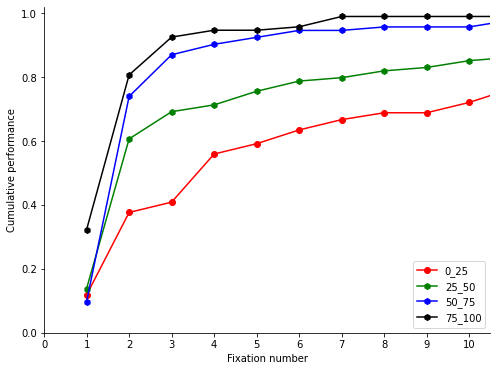

In [ ]:
plt.figure(figsize=(8, 6))
l1, = plt.plot(range(1, len(IVSN_CON_0_25_accu)), IVSN_0_25_accu[1:], color ='red', marker = 'o', linestyle = '-')
l2, = plt.plot(range(1, len(IVSN_CON_25_50_accu)), IVSN_25_50_accu[1:], color ='green', marker = 'h', linestyle = '-')
l3, = plt.plot(range(1, len(IVSN_CON_50_75_accu)), IVSN_50_75_accu[1:], color ='blue', marker = 'h', linestyle = '-')
l4, = plt.plot(range(1, len(IVSN_CON_75_100_accu)), IVSN_75_100_accu[1:], color ='black', marker = 'h', linestyle = '-')

plt.legend([l1, l2, l3, l4], ["0_25", "25_50", "50_75", "75_100"], loc='lower right')
plt.axis([0, 10.5, 0, 1.02])
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Fixation number')
plt.ylabel('Cumulative performance')

Text(0, 0.5, 'Cumulative performance')

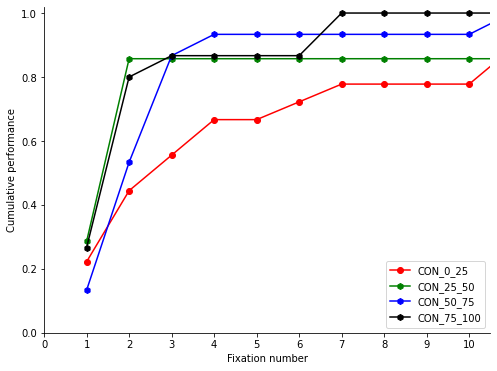

In [ ]:
plt.figure(figsize=(8, 6))
l1, = plt.plot(range(1, len(IVSN_CON_0_25_accu)), IVSN_CON_0_25_accu[1:], color ='red', marker = 'o', linestyle = '-')
l2, = plt.plot(range(1, len(IVSN_CON_25_50_accu)), IVSN_CON_25_50_accu[1:], color ='green', marker = 'h', linestyle = '-')
l3, = plt.plot(range(1, len(IVSN_CON_50_75_accu)), IVSN_CON_50_75_accu[1:], color ='blue', marker = 'h', linestyle = '-')
l4, = plt.plot(range(1, len(IVSN_CON_75_100_accu)), IVSN_CON_75_100_accu[1:], color ='black', marker = 'h', linestyle = '-')

plt.legend([l1, l2, l3, l4], ["CON_0_25", "CON_25_50", "CON_50_75", "CON_75_100"], loc='lower right')
plt.axis([0, 10.5, 0, 1.02])
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Fixation number')
plt.ylabel('Cumulative performance')

Text(0, 0.5, 'Cumulative performance')

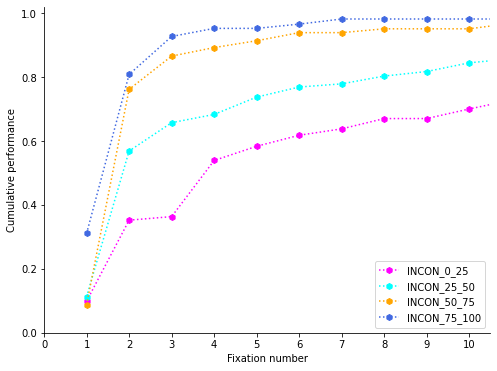

In [ ]:
plt.figure(figsize=(8, 6))

l1, = plt.plot(range(1, len(IVSN_INCON_0_25_accu)), IVSN_INCON_0_25_accu[1:], color ='magenta', marker = 'h', linestyle = ':')
l2, = plt.plot(range(1, len(IVSN_INCON_25_50_accu)), IVSN_INCON_25_50_accu[1:], color ='aqua', marker = 'h', linestyle = ':')
l3, = plt.plot(range(1, len(IVSN_INCON_50_75_accu)), IVSN_INCON_50_75_accu[1:], color ='orange', marker = 'h', linestyle = ':')
l4, = plt.plot(range(1, len(IVSN_INCON_75_100_accu)), IVSN_INCON_75_100_accu[1:], color ='royalblue', marker = 'h', linestyle = ':')

plt.legend([l1, l2, l3, l4], ["INCON_0_25", "INCON_25_50", "INCON_50_75", "INCON_75_100"], loc='lower right')
plt.axis([0, 10.5, 0, 1.02])
x_major_locator=MultipleLocator(1)
y_major_locator=MultipleLocator(0.2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Fixation number')
plt.ylabel('Cumulative performance')

In [ ]:
bin_info.keys()

dict_keys(['con_(0, 25]', 'con_(25, 50]', 'con_(50, 75]', 'con_(75, 100]', 'incon_(0, 25]', 'incon_(25, 50]', 'incon_(50, 75]', 'incon_(75, 100]'])

In [ ]:
bin_info_IVSN = {}
bin_info_IVSN['(0, 25]'], bin_info_IVSN['(25, 50]'], bin_info_IVSN['(50, 75]'], bin_info_IVSN['(75, 100]'] = IVSN_0_25_accu, IVSN_25_50_accu, IVSN_50_75_accu, IVSN_75_100_accu
bin_info_IVSN['con_(0, 25]'], bin_info_IVSN['con_(25, 50]'], bin_info_IVSN['con_(50, 75]'], bin_info_IVSN['con_(75, 100]'] = IVSN_CON_0_25_accu, IVSN_CON_25_50_accu, IVSN_CON_50_75_accu, IVSN_CON_75_100_accu
bin_info_IVSN['incon_(0, 25]'], bin_info_IVSN['incon_(25, 50]'], bin_info_IVSN['incon_(50, 75]'], bin_info_IVSN['incon_(75, 100]'] = IVSN_INCON_0_25_accu, IVSN_INCON_25_50_accu, IVSN_INCON_50_75_accu, IVSN_INCON_75_100_accu

In [ ]:
with open("./SCEGRAM(invariant)_bin_IVSN_accu_performance_all.pkl", "wb") as tf:
    pickle.dump(bin_info_IVSN, tf)


In [ ]:
def scanPathDraw(paths, attention, img_orignal=None):
    img_blend = None
    if img_orignal is not None: 
        img_blend = to_pil_image(attention * transforms.ToTensor()(img_orignal))
    else:
        img_blend = to_pil_image(attention)
        
    img = cv.cvtColor(np.asarray(img_blend),cv.COLOR_RGB2BGR) 
    # draw circle and numbers
    cv.circle(img,(256,160),5,(0,255,255),2,1)
    count = 0
    for path in paths:
        count += 1
        cx, cy = path[0], path[1]
        cv.circle(img,(cx, cy),5,(0,255,255),2,1)
        cv.putText(img, str(count), (cx, cy - 15), cv.FONT_HERSHEY_COMPLEX, 0.6, (0,255,255), 1)

    # draw the arrows
    for i in range(len(paths)):
        if i == 0:
            cx, cy = paths[i][0], paths[i][1]
            cv.arrowedLine(img, (256,160), (cx, cy), (0,255,255), 2, 0, 0, 0.1)
        else:
            cx_start, cy_start = paths[i-1][0], paths[i-1][1]
            cx_end, cy_end = paths[i][0], paths[i][1]
            cv.arrowedLine(img,(cx_start, cy_start), (cx_end, cy_end), (0,255,255), 2, 0, 0, 0.07)

    res = Image.fromarray(cv.cvtColor(img,cv.COLOR_BGR2RGB))

    return res

In [ ]:
class SCEGRAM_show(Dataset): 
    def __init__(self, info_dir, context_dir, target_dir, context_size, target_size, is_transform=True): 
        df_info = pd.read_excel(info_dir)
        self.df_info = df_info[df_info.obj_name != 'XXX']
        self.image_width = self.df_info.iloc[0, :]['sce_width']
        self.image_height = self.df_info.iloc[0, :]['sce_height']
        self.target_dic = {filename[3:-4]: filename for filename in os.listdir(target_dir)}
        self.context_dir = context_dir
        self.target_dir = target_dir
        self.is_transform = is_transform

        self.context_transform = transforms.Compose([
            transforms.Resize(context_size),
            transforms.ToTensor()
        ]) 

        self.target_transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor()
        ]) 

    def __len__(self):
        return len(self.df_info)
    
    def __getitem__(self, idx):
        idx_info = self.df_info.iloc[idx, :]
        context_file = os.path.join(self.context_dir, idx_info['sce_file_name'])
        target_file = os.path.join(self.target_dir, self.target_dic[idx_info['obj_name']])
        x_center, y_center, w, h = idx_info['obj_x_center'], idx_info['obj_y_center'], idx_info['obj_width'], idx_info['obj_height']
        bbox_relative = [(x_center-0.5*w)/self.image_width, (y_center-0.5*h)/self.image_height, w/self.image_width, h/self.image_height]
        img_category = idx_info['sce_file_name'][:-4].split('_')[-1]
        
        # process context img, target img
        img = cv2.imread(context_file)
        target = cv2.imread(target_file)
        
        # calculate the bounding box tensor
        bbox_relative = torch.tensor(bbox_relative)

        if self.is_transform:
            img_PIL = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            target_PIL = Image.fromarray(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))
            img = self.context_transform(img_PIL)
            target = self.target_transform(target_PIL)

        return img, target, bbox_relative, img_category

In [ ]:
nomal_dataset = SCEGRAM_show(info_dir, context_dir, target_dir, context_size, target_size)

In [ ]:
bin_info.keys()

dict_keys(['con_(0, 25]', 'con_(25, 50]', 'con_(50, 75]', 'con_(75, 100]', 'incon_(0, 25]', 'incon_(25, 50]', 'incon_(50, 75]', 'incon_(75, 100]'])

In [ ]:
bin_info['incon_(75, 100]']

array([ 13,  15,  17,  26,  27,  29,  40,  43,  45,  47,  52,  53,  59,
        64,  65,  67,  69,  70,  71, 107, 136, 137, 139, 142, 143, 165,
       167, 169, 171, 173, 176, 178, 181, 182, 183, 184, 185, 188, 189,
       190, 221, 226, 229, 232, 233, 245, 253, 254, 255, 256, 257, 260,
       262, 263, 265, 267, 278, 280, 281, 290, 292, 295, 299, 321, 323,
       328, 331, 332, 333, 334, 335, 346, 347, 349, 356, 357, 358, 359])

In [ ]:
index = 281
image, target_image, bbox_relative = pic_analysis_scegram(nomal_dataset, index, (512, 320))
image_rec = target_rec(image, bbox_relative)

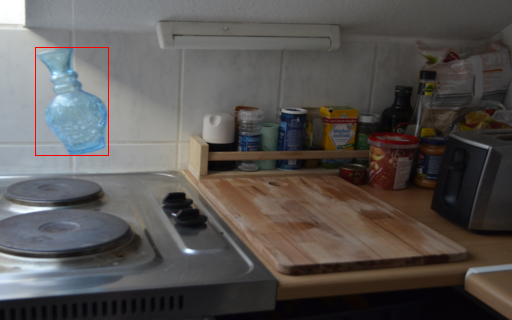

In [ ]:
image_rec

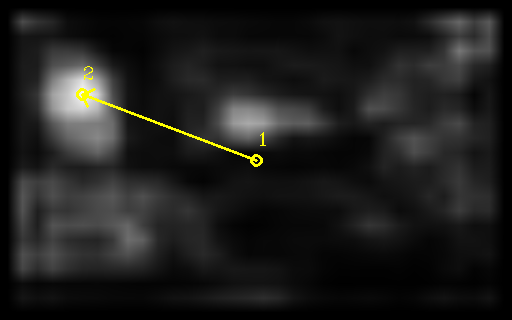

In [ ]:
scanPathDraw(scanpath[index], attention_map[index])